In [1]:
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

我们将生成一个人工数据集。在训练数据集和测试数据集中，给定样本特征xx，我们使用如下的三阶多项式函数来生成该样本的标签：

y=1.2x−3.4x2+5.6x3+5+ϵ,
其中噪声项ϵϵ服从均值为0、标准差为0.01的正态分布。训练数据集和测试数据集的样本数都设为100。

# 生成数据集

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5

In [3]:
features = torch.randn((n_train + n_test, 1))  # torch.Size([200, 1])

# torch.Size([200, 3])
# torch.pow(features, 2) 返回features的平方。
# torch.cat在给定维度上连接给定序列张量的序列
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)  

In [6]:
# 这个就是利用多项式生成数据
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
     + true_w[2] * poly_features[:, 2] + true_b)
# 加上一点噪声
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [7]:
features[:2], poly_features[:2], labels[:2]

(tensor([[0.3269],
         [0.3669]]),
 tensor([[0.3269, 0.1069, 0.0349],
         [0.3669, 0.1346, 0.0494]]),
 tensor([5.2214, 5.2602]))

In [23]:
poly_features.shape

torch.Size([200, 3])

# 定义，训练和测试模型

我们先定义作图函数semilogy，其中 yy 轴使用了对数尺度。

In [18]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
            legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [19]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了

    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)


final epoch: train loss 0.0011121885618194938 test loss 0.0020140702836215496
weight: tensor([[ 1.2544, -3.3704,  5.5784]]) 
bias: tensor([4.9768])


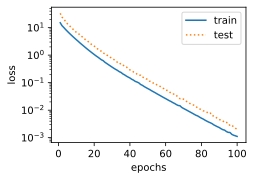

In [20]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], 
            labels[:n_train], labels[n_train:])

final epoch: train loss 50.29838943481445 test loss 109.8902587890625
weight: tensor([[12.8088]]) 
bias: tensor([3.9134])


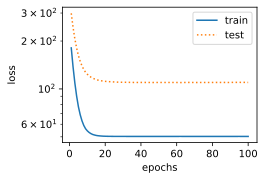

In [21]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])


final epoch: train loss 0.2703491449356079 test loss 311.7314147949219
weight: tensor([[ 1.8072,  0.7301, -0.3684]]) 
bias: tensor([4.0218])


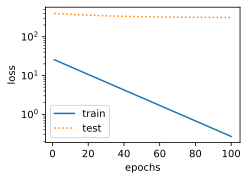

In [22]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])
